Sự thành công của Word2vec đã được chứng minh trong rất nhiều công trình NLP. 

Nhắc lại về Word2vec, nó sử dụng 1 tập copus, qua một mạng Neural biểu diễn các word thành các vector, các vector giữ lại được tính chất ngữ nghĩa. Tức các từ mang ý nghĩa similar với nhau thì gần nhau trong không gian vector. Trong NLP, đây một trong những phương thức của **word embedding**. Word2vec hiện nay được sử dụng hết sức rộng rãi.

Với Doc2vec, ngoài từ (word), ta còn có thể biểu diễn các câu (sentences) thậm chí 1 đoạn văn bản (document). Khi đó, bạn có thể dễ dàng vector hóa cả một đoạn văn bản thành một vector có số chiều cố định và nhỏ, từ đó có thể chạy bất cứ thuật toán classification cơ bản nào trên các vector đó. 

Trong notebook này, mình sẽ giới thiệu rất cơ bản basic concept để các bạn có thể hình dung Sentiment sử dụng Doc2vec như thế nào.


# Doc2vec

Doc2vec được giới thiệu bởi Google ([https://arxiv.org/pdf/1507.07998v1.pdf](https://arxiv.org/pdf/1507.07998v1.pdf)), cũng như Word2vec, có 2 model chính là: **DBOW** và **DM**

*  **DBOW** (distributed bag of words): Mô hình này đơn giản là không quan tâm thứ tự các từ, training nhanh hơn, không sử dụng local-context/neighboring. Mô hình chèn thêm 1 "word" là ParagraphID, ParagraphID này đại diện cho văn bản được training. Sau khi training xong có thể hiểu các vector ParagraphID này là vector embedded của các văn bản. Hình ảnh được mô tả trong bài báo:

![DBOW](doc2vec_dbow.jpg)

* **DM** (distributed memory): xem một paragraph là một từ, sau đó nối từ này vào tập các từ trong câu. Trong quá trình training, vector của paragraph và vector từ đều được update.

![DM](doc2vec_dm.jpg)


Tóm lại: ta xem văn bản như là một từ, docID/paragraphID được biểu diễn dạng 1-hot, được embedded vào không gian vector.

# Setup

## Modules 

Mình sử dụng `gensim`, `gensim` được implement Word2vec lẫn Doc2vec, tài liệu rất dễ đọc.
Ngoài ra còn có `numpy` để thao tác trên array, `sklearn` cho các thuật toán phân lớp. 

In [44]:
%matplotlib inline

# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy as np

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# random, itertools, matplotlib
import random
import itertools
import matplotlib.pyplot as plt

## Data

Mình có các tập data để training, gồm training và testing như sau:

* `test-neg.txt`: 12500 negative movie reviews from the test data
* `test-pos.txt`: 12500 positive movie reviews from the test data
* `train-neg.txt`: 12500 negative movie reviews from the training data
* `train-pos.txt`: 12500 positive movie reviews from the training data
* `train-unsup.txt`: 50000 Unlabelled movie reviews

Trong mỗi file data, 1 đoạn văn bản trên một dòng:

```
once again mr costner has dragged out a movie for far longer than necessary aside from the terrific sea rescue sequences of...
this is an example of why the majority of action films are the same generic and boring there s really nothing worth watching...
this film grate at the teeth and i m still wondering what the heck bill paxton was doing in this film and why the heck does...
```

## Input data vào Doc2vec

Doc2vec của `gensim` input một object `LabeledSentence`, gồm 1 tập các từ kèm theo `label` (id của paragraph), có format như sau:

```python
[['word1', 'word2', 'word3', 'lastword'], ['label1']]
```

Ta sẽ viết class `LabeledLineSentence` để đọc data txt, yield ra object `LabeledSentence` để `gensim` có thể hiểu. 

In [2]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

Ok bây giờ chúng ta feed data files vào `LabeledLineSentence`, `LabeledLineSentence` input 1 dict với key là tên file, value là `prefix` của các sentences trong văn bản.  

In [3]:
sources = {
    'data/test-neg.txt':'TEST_NEG',
    'data/test-pos.txt':'TEST_POS', 
    'data/train-neg.txt':'TRAIN_NEG', 
    'data/train-pos.txt':'TRAIN_POS', 
    'data/train-unsup.txt':'TRAIN_UNS'
}

sentences = LabeledLineSentence(sources)

# Model

## Building the Vocabulary Table

Trước tiên Doc2vec yêu cầu build Vocabulary table, 1 tập chứa tất cả các từ, lọc bỏ các từ trùng lặp, thực hiện một số thống kê. 
Chúng ta có một số tham số như sau:

* *min_count*: lọc bỏ tất cả các từ khỏi từ điển có số lần xuất hiện nhỏ hơn `min_count`.
* *window*: khoảng cách tối đa của từ hiện tại và từ predicted. Tương tự `window` trong Skip-gram model.
* *size*: số chiều của vector embedded. Thường từ trong khoảng 100-400 cho kết quả tối ưu. 
* *workers*: Số worker threads (set bằng số core của máy).

In [4]:
model = Doc2Vec(min_count=1, window=10, size=100, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences.to_array())


## Training Doc2Vec

Mình sẽ train model với 10 epochs. Nếu có thời gian bạn có thể chọn 20 hoặc 50 epochs. Mỗi epochs là một lần training trên toàn bộ dữ liệu.

Phần này có thể tốn rất nhiều thời gian, tùy cấu hình máy bạn như thế nào. 

In [9]:
model.train(sentences.sentences_perm(), total_examples=model.corpus_count, epochs=10)

58167577

## Inspecting the Model

Sau khi training, chúng ta có được các vector từ và vector văn bản. Tìm similarity của một từ (theo khoảng cách cosine).

In [10]:
model.most_similar('good')

[(u'great', 0.7514600157737732),
 (u'decent', 0.7394523620605469),
 (u'bad', 0.6599287986755371),
 (u'nice', 0.6548842191696167),
 (u'solid', 0.6304105520248413),
 (u'fine', 0.6300679445266724),
 (u'excellent', 0.619133710861206),
 (u'terrific', 0.5940879583358765),
 (u'fantastic', 0.5322197675704956),
 (u'poor', 0.5300629734992981)]

Vector của một đoạn văn trong tập negative reviews:

In [26]:
model.docvecs['TRAIN_NEG_0']

array([ -1.01556428e-01,  -3.56465846e-01,   3.44622403e-01,
         8.42040837e-01,   3.27622980e-01,  -1.11577833e+00,
        -2.24954560e-01,  -5.04830778e-01,  -1.88524842e-01,
         1.36966994e-02,  -1.20956969e+00,  -1.48627579e-01,
        -9.34836924e-01,  -1.52438581e-01,   2.31746025e-03,
         4.67331141e-01,   2.05392256e-01,   3.45028825e-02,
         1.80151880e-01,  -5.39694607e-01,  -6.49884492e-02,
         1.35365915e+00,  -5.30167639e-01,   5.87864697e-01,
         7.33038425e-01,   8.35742176e-01,   7.98877537e-01,
         2.99303561e-01,   2.93371022e-01,  -2.80979633e-01,
         5.45228899e-01,   7.07931161e-01,  -6.89087927e-01,
         4.84656468e-02,  -5.57627855e-03,   7.30554581e-01,
        -5.21582305e-01,   1.05067813e+00,  -3.70394111e-01,
         2.97508329e-01,   4.00131464e-01,  -6.46517992e-01,
         1.84185669e-01,   3.36585194e-01,  -1.15013385e+00,
         5.34893453e-01,   1.59992184e-02,  -2.28792682e-01,
         6.48893565e-02,

## Saving and Loading Models

Lưu xuống và tái sử dụng

In [27]:
model.save('./imdb.d2v')

Khi sử dụng, model chỉ cần load lại 

In [28]:
model = Doc2Vec.load('./imdb.d2v')

# Classifying Sentiments

Từ các vector văn bản trên, ta có thể sử dụng chúng để huấn luyện các bộ phân lớp. Trước tiên mình extract các vector này từ Doc2vec ra. Ở trên chúng ta có 25000 đoạn training reviews (12500 positive, 12500 negative), tức chúng ta sẽ có 25000 vector.

Chúng ta tạo 2 biến `X_train` và `y_train` để lưu lại các vectors và labels tương ứng. 

In [29]:
X_train = np.zeros((25000, 100))
y_train = np.zeros(25000)

for i in range(12500):
    prefix_train_pos = 'TRAIN_POS_' + str(i)
    prefix_train_neg = 'TRAIN_NEG_' + str(i)
    X_train[i] = model.docvecs[prefix_train_pos]
    X_train[12500 + i] = model.docvecs[prefix_train_neg]
    y_train[i] = 1
    y_train[12500 + i] = 0

`X_train` sẽ là một list các vector:

In [30]:
print X_train

[[ 0.07835239 -0.74710965  0.69579625 ...,  1.26008689 -0.20882945
   0.15453815]
 [-0.30765828 -1.3621341  -0.04978399 ...,  1.82920146  0.83890873
  -1.24059582]
 [ 0.43396333  0.55141008  1.10285032 ..., -0.00459967 -1.20170486
   0.24269094]
 ..., 
 [-0.0061076   1.02311051  1.14070487 ...,  0.43794197 -1.44546068
   0.92352289]
 [-0.66359657 -0.14818916 -0.00780609 ..., -0.23638545  0.11614358
   0.30252352]
 [ 0.48667926  0.21486095 -0.06502845 ...,  0.73961246  0.17024654
   0.49861109]]


`y_train` sẽ là một list các label tương ứng, label 1: positive, label 0: negative.

In [31]:
print y_train

[ 1.  1.  1. ...,  0.  0.  0.]


## Testing Vectors

Tương tự với các vector để test

In [32]:
X_test = np.zeros((25000, 100))
y_test = np.zeros(25000)

for i in range(12500):
    prefix_test_pos = 'TEST_POS_' + str(i)
    prefix_test_neg = 'TEST_NEG_' + str(i)
    X_test[i] = model.docvecs[prefix_test_pos]
    X_test[12500 + i] = model.docvecs[prefix_test_neg]
    y_test[i] = 1
    y_test[12500 + i] = 0

# Classification

Từ đây bạn có thể sử dụng bất cứ thuật toán phân lớp nào, bạn có thể thực hiện tiếp bước **model selection** đến khi nào đạt kết quả tốt nhất. Ở đây mình sử dụng **Logistic Regression** và **SVM**

In [33]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Độ chính xác của thuật toán và confusion matrix:

Vẽ confusion matrix

Accuracy 0.86376
Confusion matrix, without normalization


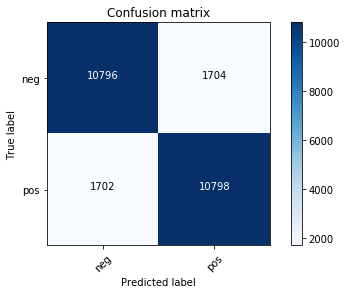

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print 'Accuracy', classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=['neg', 'pos'])

Ok, chúng ta có **87% accuracy** cho sentiment analysis với **Logistic Regression**.

Thử với **SVM**

Accuracy 0.86708
Confusion matrix, without normalization


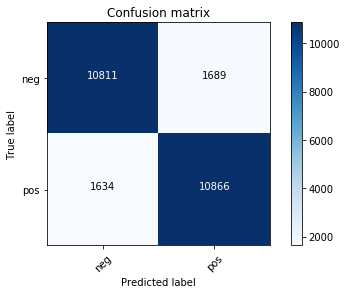

In [45]:
classifier = SVC()
classifier.fit(X_train, y_train)

print 'Accuracy', classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=['neg', 'pos'])


**SVM** cho kết quả tương tự, vẫn khá tốt ~ 86%